In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import gzip
import simplejson
import json
import time
import scipy.spatial

In [ ]:
import codecs
import os
from keras.preprocessing.text import Tokenizer as tokenizer

def get_embedding_weights(tokenizer, embedding_dim=100, fileName='data/glove.6B/glove.6B.50d.txt'):
# utils
    embedding_map = {}
    BASE_DIR = ''
    GLOVE_DIR = os.path.join(BASE_DIR, 'data/glove.6B')
    glove = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
    
    print('constructing embedding dictionary...pls wait ~2min')
    #dimension of Glove 300 Embeddings
    EMBEDDING_DIM = embedding_dim

    word_index = tokenizer.word_index
    print('Found %s unique tokens' % len(word_index))

    #load glove embeddings
    embedding_map = {}
    for line in glove:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embedding_map[word] = embedding
    glove.close()
    print('GloVe Word embeddings:', len(embedding_map))

    # nb_words contains the total length of vocab
    nb_words = len(word_index) + 1

    #get glove embeddings for each word in tokenizer.
    #word_embedding_matrix holds the embeddings dictionary
    word_embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

    for word, i in word_index.items():
        embedding_vector = embedding_map.get(word)
        if embedding_vector is not None:
            word_embedding_matrix[i] = embedding_vector

    #total words in the tokenizer not in Embedding matrix
    print('Null words in GloVe embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))
    return word_embedding_matrix

# utils
def initEmbeddingMap(fileName='glove.6B.50d.txt'):
    embedding_map = {}
    BASE_DIR = ''
    GLOVE_DIR = os.path.join(BASE_DIR, 'data/glove.6B')
    glove = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
    
    print('constructing embedding dictionary')
    embedding_map = {}
    for line in glove:
        values = line.split()
        word = values[0]
        value = np.asarray(values[1:], dtype='float32')
        embedding_map[word] = value
    glove.close()

    #pickle.dump(embedding_map, open(fileName,'wb'))
    return embedding_map

from keras.preprocessing.text import text_to_word_sequence
def clean(text):
    return text_to_word_sequence(text,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ")


import pickle
# utils - returns dict with users and movies they rated as repeated rows
# cleans review text and add to rawOutput
def initRawData(input_file, save=False):
    print('initializing raw data')
    rawInputData = []
    rawOutputData = []
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            if len(line) < 4:
                break
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rawInputDataObj = {'user':user, 'asin':item}
            rawOutputDataObj = clean(lineObj['reviewText'])
            rawInputData.append(rawInputDataObj)
            rawOutputData.append(rawOutputDataObj)
    if save:
        pickle.dump((rawInputData, rawOutputData), open(fileName,'wb'))
    return rawInputData, rawOutputData

# utils - creates dict of usrs w/ all movies rated + movies w/ all user ratings *** 
def getSparcityInfo(inputData):
	users = {}
	items = {}
	for datum in inputData:
		u = datum['user']
		i = datum['asin']
		users.setdefault(u, []).append(i)
		items.setdefault(i, []).append(u)
	return (users, items)

# utils - doesnt seem necessary
def getSetFromData(key, data):
	result = set()
	for datum in data:
		result.add(datum.get(key))
	return result

def seq_2_matrix(sequence, embedding_map):
	m = []
	for word in sequence:
		emb = embedding_map.get(word)
		if emb is not None:
			m.append(emb)
	return np.array(m)

def matrix_2_avg(emb_matrix):
	return np.mean(emb_matrix, 0)


from sklearn.feature_extraction import DictVectorizer
# utils - one hot encodes all data 
def initVecData(rawInputData, rawOutputData, embedding_map):
    print('initializing vectorized data')
    dictVect = DictVectorizer()
    vecInputData = dictVect.fit_transform(rawInputData).toarray()
    vecOutputData = [matrix_2_avg(seq_2_matrix(review, embedding_map)) for review in rawOutputData]
    if save:
        pickle.dump((vecInputData, vecOutputData), open(fileName,'wb'))
    return vecInputData, vecOutputData

def initMatInputData(rawInputData, rawOutputData, embedding_map, save=False):
    print('initializing matrix data')
    if len(rawInputData) != len(rawOutputData):
        raise ValueError("Need same size of input and output")
    users = {}
    extra_info = {}
    items = {}
    dictVect = DictVectorizer()
    for i in range(len(rawInputData)):
        vecOutput = seq_2_matrix(rawOutputData[i], embedding_map)
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        users.setdefault(user, []).append(vecOutput)
        items.setdefault(item, []).append(vecOutput)
    matUserInputData = []
    matItemInputData = []
    users = {k: np.vstack(v) for k, v in users.items()}
    items = {k: np.vstack(v) for k, v in items.items()}
    extra_info['user_seq_sizes'] = [m.shape[0] for m in users.values()]
    extra_info['item_seq_sizes'] = [m.shape[0] for m in items.values()]
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        matUserInputData.append(users.get(user))
        matItemInputData.append(items.get(item))
    if save:
        pickle.dump((matUserInputData, matItemInputData), open(fileName,'wb'))
    return matUserInputData, matItemInputData

def toKey(user, item):
    return (user, item)

def initRatingsOutputData(rawInputData, input_file, maxlines = 1000, fileName='ratingsData.p', save=True):
    try:
        ratingsData = pickle.load(open(fileName,'rb'))
        print('loaded saved ratings data')
    except (OSError, IOError) as e:
        ratingsData = []
        userItemDict = {}
        for i in range(len(rawInputData)):
            rawInput = rawInputData[i]
            userItem = toKey(rawInput['user'], rawInput['asin'])
            userItemDict[userItem] = i
            ratingsData.append(None) # check later to make sure no Nones left
        with open(input_file,'r') as f:
            for i in range(maxlines):
                line = f.readline()
                #print("line:\n",line)
                if len(line) < 4:
                    break
                #terms = line.split(',')
                lineObj = json.loads(line)
#                 user = terms[0]
#                 item = terms[1]
                user = lineObj['reviewerID']
                item = lineObj['asin']
                rating = lineObj['overall']
                #print("user:", user)
                #print("item:", item)
                #print("rating:",rating)
                #rating = float(terms[2]) / 2.5 - 1.0
                i = userItemDict.get(toKey(user, item))
                if i is not None:
                    ratingsData[i] = rating
            failure = None in ratingsData
            if failure:
                raise ValueError(str(len([r for r in ratingsData if r is None])) + " reviews did not have corresponding rating.")
        if save:
            pickle.dump(ratingsData, open(fileName,'wb'))
    return ratingsData

In [ ]:
path_to_data = "data/reviews_Amazon_Instant_Video_5.json"

In [ ]:
embedding_map = initEmbeddingMap()

In [ ]:
print(len(embedding_map))

In [ ]:
rawInputData, rawOutputData = initRawData(input_file=path_to_data, save=False)
print("Number of user/item data:", len(rawInputData))
print("Number of reviews:", len(rawOutputData))
print()
print(rawInputData[0:5])
print()
print(rawOutputData[0])
print()
print(rawOutputData[1])

In [ ]:
users, items = getSparcityInfo(rawInputData)
print(users['A3BC8O2KCL29V2'])
print()
print(items['B00F0CLHQO'])
print("Num reviews per distinct user:")
print("lenth items:", len(items))
print()
print("lenth users:", len(users))


In [ ]:
rand_idxs = np.random.permutation(len(rawOutputData))
print("Random index list:", rand_idxs)
print("Number of rand. indexes == len(data):", len(rand_idxs))
rawInputData = [rawInputData[i] for i in rinds]
rawOutputData = [rawOutputData[i] for i in rinds]


In [ ]:
vecInputData, vecOutputData = initVecData(rawInputData, rawOutputData, embedding_map, save=False)


In [ ]:
all_users = getSetFromData('user', rawInputData)
all_items = getSetFromData('asin', rawInputData)
vecInputData, vecOutputData = initVecData(rawInputData, rawOutputData, embedding_map, save=False)
vecUsers = vecInputData[:,len(all_users):]
vecItems = vecInputData[:,:len(all_items)]

"""
vecInputData:
    Is rawInputData dict of 18563 samples of userID to movieID,
    converted to one-hot encoding of
    where first 5033 col represent user encodings and remaining
    represent 1685 movieIDs
"""
print("Shape of matrix vecInputData: {}".format(vecInputData.shape))

"""
vecOutputData:
    Is rawOutputData list of reviews seperated into words where each
    word in the review is swapped for it's embedding representation i.e.
    1x50 row per word. These rows are turn into a matrix of words x 50 dims
    then you take mean of each col to get a 1x50 array (why?). These arrays
    are returned for each  18563 sample yielding a 18563x50 list matrix
"""
print("Shape of list vecOutputData: ({}, {})".format(len(vecOutputData), len(vecOutputData[0])))

"""
vecUsers | vecItems:
    Seperates the user one-hot encodings from the item encodings for each row/group
"""
vecUsers = vecInputData[:,len(all_users):]
vecItems = vecInputData[:,:len(all_items)]

print(vecUsers.shape)
print(vecItems.shape)

#print("Length of vecUsers == Num Users:", len(vecUsers[0]))
#print("Length of vecItems == Num Items:", len(vecItems[0]))

In [ ]:
ratings_file = "data/reviews_Amazon_Instant_Video_5.json"

matUserInputData, matItemInputData = initMatInputData(rawInputData, rawOutputData, embedding_map)
print(len(matUserInputData))
print(len(matUserInputData[2]))

print(len(matItemInputData))
print(len(matItemInputData[2]))

#matItemInputData

In [287]:
def initRatingsOutputData(rawInputData, input_file, save=True):
    ratingsData = []
    userItemDict = {}
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        userItem = toKey(rawInput['user'], rawInput['asin'])
        userItemDict[userItem] = i
        ratingsData.append(None) # check later to make sure no Nones left
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            #print("line:\n",line)
            if len(line) < 4:
                break
            #terms = line.split(',')
            lineObj = json.loads(line)
#                 user = terms[0]
#                 item = terms[1]
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rating = lineObj['overall']
            #rating = float(terms[2]) / 2.5 - 1.0
            i = userItemDict.get(toKey(user, item))
            if i is not None:
                ratingsData[i] = rating
        failure = None in ratingsData
        if failure:
            raise ValueError(str(len([r for r in ratingsData if r is None])) + " reviews did not have corresponding rating.")
    if save:
        pickle.dump(ratingsData, open(fileName,'wb'))
    return ratingsData

"""
rData:
    Index each unique key pair (usr/movie) in rawInputData then assigns the correct
    rating to the ratings list based on that index of the key pair in dict userItemDict.
    Returns list of scores ordered correctly
"""
rData = initRatingsOutputData(rawInputData, input_file=ratings_file,save=False)


18563

In [308]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.merge import Dot
from keras.callbacks import EarlyStopping

def create_factorization_model(user_size, item_size, hidden_size):
    inputU = Input(shape=(user_size,))
    inputI = Input(shape=(item_size,))
    hiddenU = Dense(hidden_size)(inputU)
    hiddenI = Dense(hidden_size)(inputI)
    dotproduct = Dot(axes=1)([hiddenU, hiddenI])
    model = Model(inputs=[inputU, inputI], outputs=[dotproduct])
    model.compile(optimizer='adam', loss='mse')
    return model

def matrix_factorization(vecUsers, vecItems, ratingsData, hidden_size=4, epochs=100, training=0.9):
    model = create_factorization_model(vecUsers.shape[1], vecItems.shape[1], hidden_size)

    trainingN = int(len(ratingsData) * training) if type(training) is float else training

    train_inputs = [vecUsers[:trainingN], vecItems[:trainingN]]
    train_outputs = ratingsData[:trainingN]
    test_inputs = [vecUsers[trainingN:], vecItems[trainingN:]]
    test_outputs = ratingsData[trainingN:]
    print(model.summary())

    early_stopping = EarlyStopping(monitor='loss', patience=8)
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=12)
    batch_size = 32
    model.fit(train_inputs, train_outputs, validation_split=0.2, callbacks=[early_stopping, early_stopping_val], batch_size=batch_size, epochs=epochs)
    evaluate(model, train_inputs, train_outputs, test_inputs, test_outputs)

    
import matplotlib.pyplot as plt
from keras import metrics
from keras import backend as K

def evaluate(model, train_inputs, train_outputs, test_inputs, test_outputs):
    model_train_mse = model.evaluate(train_inputs, train_outputs, verbose=0)
    print("Printing a few test outputs...\n", test_outputs[0:20])
    print()
    baseline = np.mean(train_outputs)
    baseline_train_mse = np.mean((baseline - train_outputs) ** 2)
    print("baseline train mse: " + str(baseline_train_mse))
    print("model train mse: " + str(model_train_mse))
    print()

    model_test_mse = model.evaluate(test_inputs, test_outputs, verbose=1, batch_size=len(test_outputs))
    baseline_test_mse = np.mean((baseline - test_outputs) ** 2)
    print("baseline test mse: " + str(baseline_test_mse))
    print("model test mse: " + str(model_test_mse))

    jitter = lambda x : np.random.normal(x, np.std(x)/10)

    predictions = model.predict(test_inputs, verbose=0)
    print("Printing a few predictions...\n", predictions[0:20])
    tf_session = K.get_session()
    print(np.mean(metrics.mean_squared_error(predictions, test_outputs).eval(session=tf_session)))
    print(np.mean((predictions - test_outputs) ** 2))
    plt.scatter(jitter(predictions), jitter(test_outputs))
    plt.show()

(18563, 1685)
(18563, 1685)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1685)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1685)         0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 4)            6744        input_17[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 4)            6744        input_18[0][0]                   
_________________________________________________________________________________

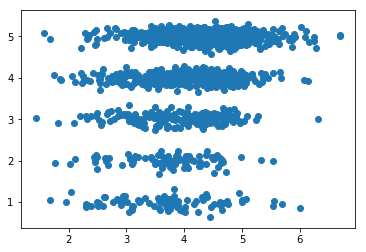

In [309]:
print(vecUsers.shape)
print(vecItems.shape)

matrix_factorization(vecUsers, vecItems, rData, epochs=150, training=.9)

In [ ]:
path_to_data = "data/reviews_Amazon_Instant_Video_5.json.gz"
raw_data = [json.loads(i) for i in gzip.open(path_to_data, "rt")]
raw_data = raw_data[:100]
data = pd.DataFrame(raw_data)

print("\ncolumn names:\n", data.columns)

reviewers = data["reviewerID"].unique()
num_reviewers = len(reviewers)
movies = data["asin"].unique()
num_movies = len(movies)

print("number unique reviewers: ", num_reviewers)
print("number unique movies: ", num_movies)
print("\nExample review:\n")
print(data[['reviewerID','reviewText']])

In [ ]:
# create int-to-name dictionaries for each - Q: Juice why do we need?
reviewer_to_num = {reviewer: idx for idx, reviewer in enumerate(reviewers)}
num_to_reviewer = {reviewer_to_num[reviewer]: reviewer for reviewer in reviewer_to_num}
product_to_num = {product: idx for idx, product in enumerate(products)}
num_to_product = {product_to_num[product]: product for product in product_to_num}

num_to_movie

In [ ]:
def populate_user_product_review_matrix(dimensions, dataset):
    assert isinstance(dataset, pd.DataFrame)
    ret_matrix = np.zeros(dimensions)
    for idx, row in dataset.iterrows():
        ret_matrix[reviewer_to_num[row["reviewerID"]], product_to_num[row["asin"]]] = row["overall"]
    return ret_matrix

In [ ]:
# get test data indices
frac_test = 0.1
test_indices = np.random.choice(num_reviews,
                                size=int(num_reviews * frac_test),
                                replace=False)

# split raw data into train/test
raw_test = data.iloc[test_indices, :]
raw_train = data.drop(test_indices).dropna()

# get dimensions of the matrices
dim = (num_reviewers, num_products)
test_matrix = populate_user_product_review_matrix(dim, raw_test)
train_matrix = populate_user_product_review_matrix(dim, raw_train)

# self.cos_sim_mat = np.zeros((self.num_products, self.num_products))
# for root_prod_idx, prod_ratings in enumerate(self.train_matrix.T):
#     for comp_prod_idx, comp_ratings in enumerate(self.train_matrix.T):
#         if comp_prod_idx >= root_prod_idx:
#             self.cos_sim_mat[root_prod_idx, comp_prod_idx] = 1 - scipy.spatial.distance.cosine(prod_ratings,
#                                                                                                comp_ratings)

# self.test = self.permute_matrix(self.test_matrix)
# self.train = self.permute_matrix(self.train_matrix)

print(train_matrix)

In [ ]:
train_matrix

In [ ]:
def clean(text, token):
    return text_to_word_sequence(text,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ")
def agg_reviews(input_file):
    reviews = []
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            lineObj = json.loads(line)
            review = lineObj['reviewText']
            reviews.append(review) 
    return reviews

def process(input_file, token):
    reviews = []
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            lineObj = json.loads(line)
            review = lineObj['reviewText']
            clean_review = clean(review, token)
            reviews.append(clean_review)
    return reviews

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

path_to_data = "data/reviews_Amazon_Instant_Video_5.json"
raw_reviews = agg_reviews(path_to_data)
print(len(raw_reviews))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_reviews)

In [ ]:
reviews = process(path_to_data, tokenizer)
x = reviews[100]
print(len(reviews))


In [ ]:
train_seq = tokenizer.texts_to_sequences(raw_reviews)
x1 = np.hstack(train_seq)
print(x1.shape)
train_pad = sequence.pad_sequences(train_seq, maxlen = 250)
train_pad.shape

In [ ]:
from keras.datasets import imdb

top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [ ]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)

In [ ]:
X_train.shape